In [337]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit

In [338]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

def showSystemInfo(tf):
    display(tf)
    print('poles: ', [np.round(val, 3) for val in ctl.poles(tf)])
    print('tf:    ', sympyFunction(tf))

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [339]:
s = ctl.TransferFunction.s
G = (221.964623247066*s**2 + 59.0744616073618*s - 1.10066668392427)/(1.0*s**2 + 1.57077381490782*s + 0.614309170752948)

G_bkp = G
G

TransferFunction(array([221.96462325,  59.07446161,  -1.10066668]), array([1.        , 1.57077381, 0.61430917]))

polos:  (-0.836+0j) (-0.735+0j)
zeros:  (-0.284+0j) (0.017+0j)


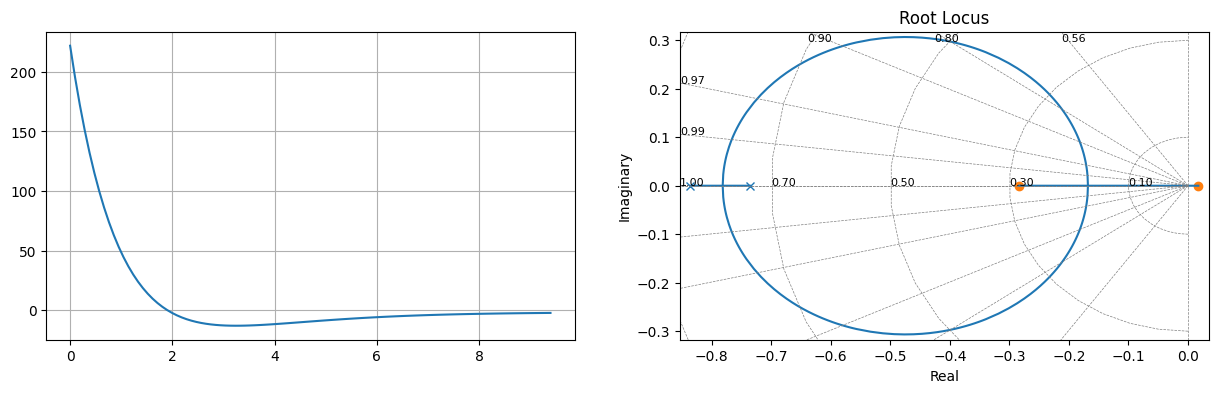

In [340]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# INFORMAÇÕES DA RESPOSTA

In [341]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 'inf',
 'peakValue': 221.964623247066,
 'peakTime': 0.0,
 'settlingTime': None,
 'finalValue': -2.3286092499416213,
 'error': 1.3286092499416213}

# CONTROLADOR
- Encontrando as constantes do controlador $C(s)$

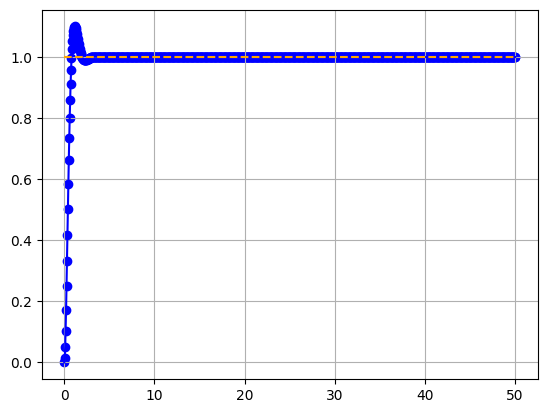

In [342]:
Ts = 2
UP = 0.1
stopTime = 50

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s = ctl.TransferFunction.s
T = np.linspace(0, stopTime, 1000)

tData, desired = ctl.step_response(Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2), T=T)
plt.scatter(tData, desired, color='blue')
plt.plot(tData, desired, color='blue')
plt.plot(tData, [1 for i in tData], '--', color='orange')
plt.grid()

In [343]:
def C(s, a, b, c, d, e, f):
    s = ctl.TransferFunction.s
    G_c = (a*s**2 + b*s + c)/(d*s**2 + e*s + f)
    
    G_feedback = ctl.feedback(G*G_c, 1)
    return ctl.step_response(G_feedback, T=tData)[1] # response

def getFunction(xDados, yDados):
    coeficientes = curve_fit(C, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [344]:
coefs = getFunction(tData, desired)  
coefs

[-7.300449017973659,
 88.93950582312483,
 352.1662541674834,
 16469.492624130562,
 -509.63848688384917,
 8.30844281469641]

In [349]:
a, b, c, d, e, f = coefs
s = ctl.TransferFunction.s
C = (a*s**2 + b*s + c)/(d*s**2 + e*s + f)

showSystemInfo(C)

TransferFunction(array([ -7.30044902,  88.93950582, 352.16625417]), array([ 1.64694926e+04, -5.09638487e+02,  8.30844281e+00]))

poles:  [(0.015+0.016j), (0.015-0.016j)]
tf:     (-7.30044901797366*s**2 + 88.9395058231248*s + 352.166254167483)/(16469.4926241306*s**2 - 509.638486883849*s + 8.30844281469641)


In [346]:
G_feedback = ctl.feedback(G*C, 1)
showSystemInfo(G_feedback)

TransferFunction(array([-1620.44141581, 19310.15380658, 83430.53870975, 20706.13911028,
        -387.61766316]), array([14849.05120832, 44670.3630785 , 92755.68071895, 20406.11419844,
        -382.51371055]))

poles:  [(-1.379+1.913j), (-1.379-1.913j), (-0.267+0j), (0.017+0j)]
tf:     (-1620.44141580894*s**4 + 19310.1538065813*s**3 + 83430.5387097536*s**2 + 20706.1391102812*s - 387.617663164556)/(14849.0512083216*s**4 + 44670.3630784993*s**3 + 92755.6807189534*s**2 + 20406.1141984358*s - 382.513710548811)


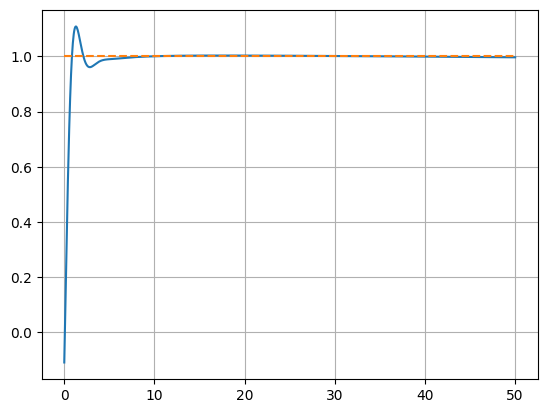

In [353]:
tData = np.linspace(0, stopTime, 1000)
time, response = ctl.step_response(G_feedback, T=tData)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()